- 다수결 투표를 기반으로 예측 만들기
- 중복을 허용하여 랜덤하게 훈련 데이터셋을 뽑는 배깅을 사용해서 과대적합 감소하기
- 앞선 모델의 오차를 학습하는 약한 학습기로 구성된 부스팅으로 강력한 모델 구축하기

# 1.앙상블 학습

- 앙상블 학습의 목표는 여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성하는 것
- 과반수 투표(major voting)는 분류기의 과반수가 예측한 클래스 레이블을 선택하는 단순한 방법
- 50% 이상 투표를 받은 클래스 레이블을 선택
- 다중 클래스의 문제에 있어서는 일반화함 (다수결 투표 - plurality voting)
- 가장 많은 투표(최빈값)를 받은 클래스 레이블을 선택함
- 훈련 데이터셋을 사용하여 $m$개의 다른 분류기($C_1,\cdots,C_m$)를 훈련 시킴
- 앙상블 방법에 따라 결정 트리, 서포트 벡터 머신, 로지스틱 회귀 분류기와 같은 여러 가지 알고리즘을 사용하여 구축
- 같은 분류 알고리즘을 사용하고 훈련데이터셋의 부분 집합을 달리하여 학습할 수도 있음
- 유명한 앙상블 기법은 RandomForest
- 과반수 투표나 다수결 투표로 클래스 레이블을 예측하려면 개별 분류기 $C_j$의 예측 레이블을 모아 가장 많은 표를 받은 레이블 $\hat{y}$를 선택
$$
\hat{y} = mode \left\{ C_1(\mathbf{x}), C_2(\mathbf{x}), \cdots, C_m(\mathbf{x}) \right\}
$$
- class1=-1 이고 class2=+1인 이진 분류 작업에서 과반수 투표 예측은 다음과 같이 쓸 수 있음
$$
C(\mathbf{x})=sign \left [ \sum_j^m C_j(\mathbf{x})\right ] = \begin{cases} 1 & \sum_j C_j(\mathbf{x}) > 0 \,일\,때 \\ 
                                                                            -1 & 그\,외
                                                            \end{cases}
$$

**앙상블 방법이 개별 분류기보다 성능이 뛰어난 이유**

- 이진 분류 작업에 대해 동일한 에러율 $\varepsilon$을 가진 $n$개의 분류기를 가정
- 또한 모든 분류기는 독립적이고 발생하는 오차는 서로 상관관계가 없다고 가정
- 이러한 가정하에 분류기의 앙상블이 만드는 오차 확률을 이항 분포의 확률 질량 함수로 표현할 수 있음
$$
P(y \geq k) = \sum_k^n {n \choose k}\varepsilon^k(1-\varepsilon)^{n-k}=\varepsilon_{ensemble}
$$
- 여기서 ${n \choose k}$는 이항계수로 $n$개의 원소에서 $k$개를 뽑는 조합의 가짓수
- 이는 앙상블의 예측이 틀릴 확률을 계산 함
- 구체적인 계산 결과는 다음과 같이 나타남 ($n=11,\,k=6$ 가정)
$$
P(y \geq 6) = \sum_{k=6}^{11} {11 \choose k}0.25^k(1-0.25)^{11-k}=0.034
$$

In [1]:
# 확률 질량 함수 구현
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k)*error**k*(1-error)**(n_classifier-k) for k in range(k_start, n_classifier+1)]
    return sum(probs)

ensemble_error(11, .25)

0.03432750701904297

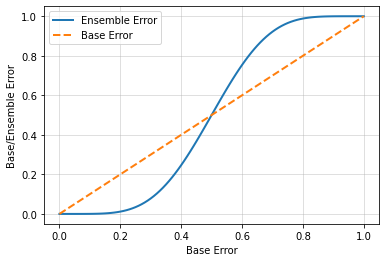

In [2]:
# 분류기 에러가 0~1 까지 걸쳐 있을 때 앙상블의 에러율을 계산
import numpy as np
import matplotlib.pyplot as plt

error_range=np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble Error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base Error', linewidth=2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='best')
plt.grid(alpha=.5)
plt.show()

- 앙상블의 에러 확률은 개별 분류기보다 좋음
- 다만 개별 분류기가 무작위 추측보다 성능이 좋아야 함($\varepsilon < 0.5$)

# 2.다수결 투표를 사용한 분류 앙상블

## 2.1.간단한 다수결 투표 분류기 구현

- 여러 가지 분류 모델의 신뢰도에 가중치를 부여하여 연결할 수 있음
- 특정 데이터셋에서 개별 분류기의 약점을 보완하는 강력한 메타 분류기를 구축하는 것을 목표로 함
- 수학적으로 표현하면 가중치가 적용된 다수결 투표는 다음과 같이 쓸 수 있음
$$
\hat{y}=\arg \max_i \sum_{j=1}^m w_j\chi_A (C_j(\mathbf{x})=i)
$$
- 여기서 $w_j$는 개별 분류기 $C_j$에 연관된 가중치
- $\hat{y}$는 앙상블이 예측한 클래스 레이블
- $A$는 고유한 클래스 레이블의 집합
- $\chi_{A}$는 특성 함수 또는 지시 함수
- 이 함수는 $j$번째 분류기의 예측 클래스가 $i$일 때 $(C_j(\mathbf{x})=i)$ 1을 반환
- 가중치가 동일하면 식은 다음과 같이 쓸 수 있음
$$
\hat{y}=mode \left\{ C_1(\mathbf{x}), C_2(\mathbf{x}), \cdots, C_m(\mathbf{x}) \right\}
$$

In [3]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

- `predict_proba` 메서드에서 예측 클래스 레이블의 확률을 반환할 수 있음
- 앙상블 분류기가 잘 보정되어 있다면 다수결 투표에서 클래스 레이블 대신 예측 클래스 확률을 사용하는 것이 좋음
$$
\hat{y}=\arg \max \sum_{j=1}^m w_j p_{ij}
$$
- 여기서 $P_{ij}$는 클래스 레이블 $i$에 대한 $j$번째 분류기의 예측 확률

In [4]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[.2, .2, .6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ 다수결 투표 앙상블 분류기
    
    매개변수
    ---------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
        
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됨
        'probability'면 확률 합이 가장 큰 인덱스로 클래스 레이블을 예측 (보정된 분류기에)
        
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값 None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중됨
        'weights=None'이면 동일한 가중치로 취급됨
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기 학습
        
        매개변수
        ------------
        X : {배열 타입, 희소 행렬}, 크기 = [n_samples, n_features]
            훈련 샘플 행렬
            
        y : 배열 타입, 크기 = [n_samples]
            타겟 클래스 레이블 벡터
            
        반환값
        -----------
        self : 객체
        """
        
        # 인자 전달이 유효하지 않은 것들에 대한 오류 메시지 출력
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError('vote는 "probability" 또는 "classlabel"이어야 할 수 있습니다.', "; (vote=%r)이 입력되었습니다." % self.vote)
        
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다.', f'; 가중치 {len(self.weight)} 개, 분류기 {len(self.classifiers)} 개')
        
        # self.predict 메서드에서 np.argmax를 호출 할 때
        # 클래스 레이블이 0부터 시작 되어야 하므로 LabelEncoder 사용
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """X에 대한 클래스 레이블 예측
        
        매개변수
        -----------
        X : {배열 타입, 희소 행렬}, 크기 = [n_samples, n_features]
            샘플 데이터 행렬
            
        반환값
        -----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블        
        """
        
        if self.vote=='probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote
        
    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측
        
        매개변수
        -----------
        X : {배열 타입, 희소 행렬}, 크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        -----------
        avg_proba : 배열 타입, 크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

- `BaseEstimator`와 `ClassifierMixin` 클래스를 상속하여 기본적인 기능을 넣음
- 여기에는 분류기의 매개변수를 설정하고 반환하는 `get_params`와 `set_params` 메서드가 있음
- 또한 예측 정확도를 계산하는 `score` 메서드가 포함되어 있음
    - `BaseEstimator`로 부터 상속받는 `get_params`와 `set_params` 메서드는 사이킷런의 파이프라인과 그리드 탐색에 곡 필요한 메서드
    - 이는 생성자에 명시된 매개변수만 참조하므로 `__init__` 함수에 `*args`나 `**kargs`를 사용해서는 안됨
    - `ClassifierMixin` 클래스에서 상속되는 `score` 메서드는 정확도를 계산
    - 이와 비슷하게 회귀 모델의 경우 `RegressorMixin`을 상속하며 $R^2$ 점수를 계산하는 `score` 메서드가 추가
- 앙상블에 있는 각 분류기의 매개변수에 접근하기 위해 `_name_estimators` 함수를 사용
- `get_params` 메서드를 정의

## 2.2.다수결 투표 방식을 사용하여 예측 만들기

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SDS
from sklearn.preprocessing import LabelEncoder as LE
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LE()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1, stratify=y)

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline
clf1 = LGR(penalty='l2', C=.001, random_state=1)
clf2 = DTC(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNN(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', SDS()], ['clf', clf1]])
pipe3 = Pipeline([['sc', SDS()], ['clf', clf3]])


clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']

all_clfs = [pipe1, clf2, pipe3, mv_clf]

print('10겹 교차 검증')
for clf, label in zip(all_clfs, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print("ROU AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10겹 교차 검증
ROU AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROU AUC: 0.87 (+/- 0.18) [Decision Tree]
ROU AUC: 0.85 (+/- 0.13) [KNN]
ROU AUC: 0.98 (+/- 0.05) [Majority Voting]


**사이킷런의 VotingClassifier**

- `sklearn.ensemble.VotingClassifier` 로 0.17버전 이상에서 사용할 수 있음
- `estimators` 매개변수에는 분류기 이름과 객체로 구성된 튜플 리스트를 입력
- `VotingClassifier`는 `voting='hard'`일 경우 `predict_proba` 메서드를 지원하지 않음
- ROC AUC를 계산하기 위해서는 예측 확률이 필요하므로 `voting='soft'`로 지정

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')
scores = cross_validate(estimator=vc, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print("ROU AUC: %0.2f (+/- %0.2f) [%s]" % (scores['test_score'].mean(), scores['test_score'].std(), 'VotingClassifier'))

# VotingClassifier의 fit 메서드를 호출할 때, verbose 매개변수를 True로 지정
vc.set_params(verbose=True)
vc = vc.fit(X_train, y_train)

# voting='soft'일 대 predict 메서드는 predict_proba 메서드에서 얻은 가장 큰 확률 클래스를 예측으로 삼음
# predict_proba 메서드는 각 분류기의 클래스 확률을 평균하여 반환
vc.predict_proba(X_test[:10])

ROU AUC: 0.98 (+/- 0.05) [VotingClassifier]
[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

## 2.3.앙상블 분류기의 평가와 튜닝

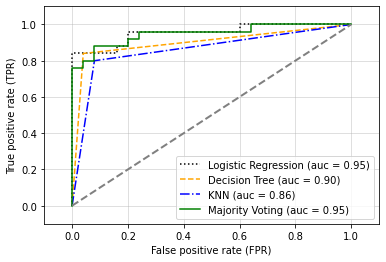

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clfs, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='best')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])
plt.grid(alpha=.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

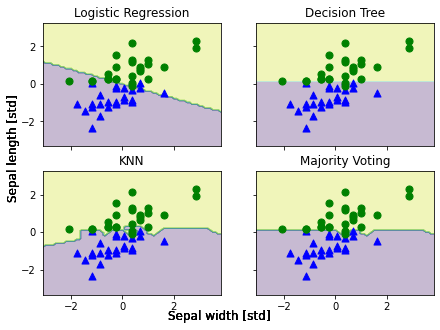

In [10]:
sc = SDS()
X_train_std = sc.fit_transform(X_train)

from itertools import product
x_min = X_train_std[:, 0].min()-1
x_max = X_train_std[:, 0].max()+1
y_min = X_train_std[:, 1].min()-1
y_max = X_train_std[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axrr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clfs, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axrr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=.3)
    axrr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axrr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o', s=50)
    axrr[idx[0], idx[1]].set_title(tt)
    plt.text(-4.5, -4.5, s='Sepal width [std]', ha='center', va='center', fontsize=12)
    plt.text(-12.5, 4.5, s='Sepal length [std]', ha='center', va='center', fontsize=12, rotation=90)
    
plt.show()

In [11]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [12]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1, 2], 'pipeline-1__clf__C':[.001, .1, 100]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [13]:
grid.cv_results_

{'mean_fit_time': array([0.00400059, 0.00300014, 0.00471466, 0.0039001 , 0.00340483,
        0.00370004]),
 'std_fit_time': array([0.00077411, 0.00044692, 0.00077015, 0.00053846, 0.0004958 ,
        0.00045848]),
 'mean_score_time': array([0.00129967, 0.00135078, 0.00170026, 0.00109999, 0.00100026,
        0.00140023]),
 'std_score_time': array([4.58121034e-04, 5.52459375e-04, 6.40445037e-04, 3.00113747e-04,
        6.92645981e-07, 6.63255685e-04]),
 'param_decisiontreeclassifier__max_depth': masked_array(data=[1, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pipeline-1__clf__C': masked_array(data=[0.001, 0.1, 100, 0.001, 0.1, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'decisiontreeclassifier__max_depth': 1,
   'pipeline-1__clf__C': 0.001},
  {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 

In [14]:
for params, mean_score, std in zip(grid.cv_results_['params'], grid.cv_results_["mean_test_score"], grid.cv_results_["std_test_score"]):
    print("%.3f +/- %0.2f %r" % (mean_score, std/2, params))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


In [15]:
grid.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}

In [16]:
grid.best_score_

0.9833333333333334

**Stacking**

- 스태킹 알고리즘은 두 개의 층을 가진 앙상블
- 첫 번째 층의 개별 분류기 예측이 두 번째 층으로 주입됨
- 두 번째 층에서 또 다른 분류기(전형적으로 로지스틱 회귀)가 최종 예측을 만들기 위해 첫 번째 층의 예측을 사용하여 학습
- 사이킷런 0.22 버전에서 `StackingClassifier`와 `StackingRegression`이 추가됨
- `estimators` 매개변수로 분류기 이름과 객체로 구성된 튜플 리스트를 입력 받음
- `fianl_estimator` 매개변수로는 최종 결정을 위한 분류기를 지정
- 매개변수 그리드를 지정할 때는 튜플에 사용한 분류기 이름을 접두사로 사용

In [17]:
from sklearn.ensemble import StackingClassifier as STKC
stack = STKC(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)], final_estimator=LGR())
params = {'dt__max_depth': [1, 2], 'lr__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=stack, param_grid=params, cv=10, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

for params, mean_score, std in zip(grid.cv_results_['params'], grid.cv_results_["mean_test_score"], grid.cv_results_["std_test_score"]):
    print("%.3f +/- %0.2f %r" % (mean_score, std/2, params))

0.950 +/- 0.07 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/- 0.07 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [18]:
# grid.get_params().keys()

In [19]:
print(f"best_score : {grid.best_score_}")
print(f"best_params : \n {grid.best_params_}")

best_score : 0.9833333333333334
best_params : 
 {'dt__max_depth': 1, 'lr__clf__C': 0.1}


# 3.배깅 : 부트스트랩 샘플링을 통한 분류 앙상블

- 앙상블에 있는 개별 분류기를 도웅일한 훈련 데이터셋으로 학습하는 것이 아니라 원본 훈련 데이터셋에서 부트스트랩(중복 허용 랜덤 샘플) 샘플을 뽑아서 사용
- 배깅은 다른 말로 bootstrap aggregating이라고도 함
- 배깅 단계마다 중복을 허용하여 랜덤하게 샘플링

## 3.1.배깅 알고리즘의 작동 방식
- 각각의 부트스트랩 샘플을 사용하여 분류기를 학습
- 일반적으로 가지치기하지 않는 결정 트리를 분류기로 사용

## 3.2.배깅으로 Wine 데이터셋의 샘플 분류

In [20]:
import pandas as pd

header_names = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                'Alcalinity of ash', 'Magnesium', 'Total phenols',
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine = pd.read_csv('./datasets/wine/wine.data', header=None)
df_wine.columns = header_names

df_wine = df_wine.loc[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine.loc[:, ['Alcohol', 'OD280/OD315 of diluted wines']].values

In [21]:
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split
le = LE()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

In [22]:
from sklearn.ensemble import BaggingClassifier as BGC
from sklearn.tree import DecisionTreeClassifier as DTC
tree = DTC(criterion='entropy', random_state=1, max_depth=None)
bag = BGC(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1, random_state=1)

In [23]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리 훈련 정확도/테스트 정확도 %.3f/%.3f'%(tree_train, tree_test))

결정 트리 훈련 정확도/테스트 정확도 1.000/0.833


In [24]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('배깅 훈련 정확도/테스트 정확도 %.3f/%.3f'%(bag_train, bag_test))

배깅 훈련 정확도/테스트 정확도 1.000/0.917


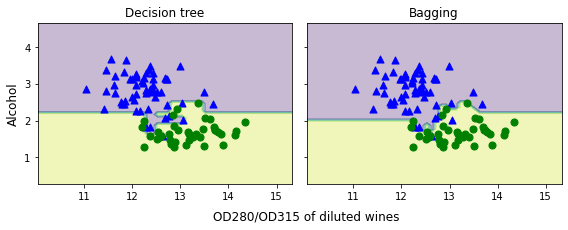

In [25]:
x_min = X_train[:, 0].min()-1
x_max = X_train[:, 0].max()+1
y_min = X_train[:, 1].min()-1
y_max = X_train[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .1), np.arange(y_min, y_max, 0.1))
f, axrr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axrr[idx].contourf(xx, yy, Z, alpha=.3)
    axrr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^', s=50)
    axrr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o', s=50)
    axrr[idx].set_title(tt)
axrr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12, transform=axrr[1].transAxes)
plt.show()

**Out of Bag**

- 랜덤 포레스트와 배깅은 모두 기본적으로 부트스트랩 샘플링을 사용하기 때문에 분류기마다 훈련에 사용하지 않는 여분 샘플이 남음
- 이를 Out of Bag (OOB)라고 함
- 이를 사용하면 검증 데이터셋을 만들지 않고 앙상블 모델을 평가할 수 있음
- 사이킷런에서는 `oob_score=True`로 설정하면 됨
- 사이킷런 랜덤 포레스트 분류의 경우 OOB 샘플에 대한 각 트리의 예측 확률을 누적하여 가장 큰 확률을 가진 클래스를 타깃과 비교하여 정확도를 계산
- 회귀의 경우에는 각 트리의 예측 평균에 대한 $R^2$ 점수를 계산

In [26]:
from sklearn.ensemble import RandomForestClassifier as RFC
rf = RFC(oob_score=True, random_state=1)
rf.fit(X_train, y_train)
print('랜덤 포레스트의 훈련 정확도/테스트 정확도: %.3f / %.3f' % (rf.score(X_train, y_train), rf.score(X_test, y_test)))
print('랜덤 포레스트의 OOB 정확도 : %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도: 1.000 / 0.917
랜덤 포레스트의 OOB 정확도 : 0.884


In [27]:
bag = BGC(base_estimator=tree, n_estimators=500, oob_score=True, random_state=1)
bag.fit(X_train, y_train)
print('배깅의 훈련 정확도/테스트 정확도: %.3f / %.3f' % (bag.score(X_train, y_train), bag.score(X_test, y_test)))
print('배깅의 OOB 정확도 : %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도: 1.000 / 0.917
배깅의 OOB 정확도 : 0.895


- 고차원 데이터셋을 사용하는 더 복잡한 분류 문제에서 단일 결정 트리가 쉽게 과대적합될 수 있음
- 이 경우 배깅 알고리즘을 이용하면 좋음
- 배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추는 데는 효과적이지 않음
- 즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못함
- 이것이 배깅을 수행할 때 편향이 낮은 모델, 예를 들면 가지치기하지 않은 결정 트리를 분류기로 사용하여 앙상블을 만드는 이유

# 4.약한 학습기를 이용한 에이다 부스트

- 부스팅에서 앙상블은 약한 학습기라고도 하는 매우 간단한 분류기로 구성됨
- 이 분류기는 랜덤 추측보다 조금 성능이 좋은 정도
- 약한 학습기의 전형적인 예는 깊이가 1인 결정 트리
- 부스팅의 핵십 아이디어는 분류하기 어려운 훈련 샘플에 초점을 맞추는 것
- 잘못 분류된 훈련 샘플을 그 다음 약한 학습기가 학습하여 앙상블 성능을 향상시킴

## 4.1.부스팅 작동 원리

- 배깅과 달리 부스팅의 초창기 방법은 중복을 허용하지 않고 훈련 데이터셋에서 랜덤 샘플을 추출하여 부분집합을 구성함
- 원본 부스팅 과정은 다음 네 개의 주요 단계를 거침
    1. 훈련 데이터셋 $D$에서 중복을 허용하지 않고 랜덤한 부분 집합 $d_1$을 뽑아 약한 학습기 $C_1$을 훈련
    2. 훈련 데이터셋에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 $d_2$를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 $C_2$를 훈련
    3. 훈련 데이터셋 $D$에서 $C_1$과 $C_2$에서 잘못 분류한 훈련 샘플 $d_3$를 찾아 세 번째 약한 학습기인 $C_3$를 훈련
    4. 약한 학습기 $C_1$, $C_2$, $C_3$를 다수결 투표로 연결
- 부스팅은 배깅 모델에 비해 분산은 물론 편향도 감소시킬 수 있음
- 실제로는 에이다부스트 같은 부스팅 알고리즘이 분산이 높다고 알려져 있음 (훈련 데이터에 과대적합되는 경향이 있음)
- 원본 부스팅 방법과는 다르게 에이다부스트는 약한 학습기를 훈련할 때 훈련 데이터셋 전체를 사용
- 훈련 샘플은 반복마다 가중치가 다시 부여되며 이 앙상블은 이전 학습기의 실수를 학습하는 강력한 분류기를 만듦
- 에이다부스트의 알고리즘
    1. 가중치 벡터 $\mathbf{w}$를 동일한 가중치로 설정 $\sum_i w_i = 1$
    2. $m$번 부스팅 반복의 $j$번째에서 다음을 수행함.
        > a. 가중치가 부여된 약한 학습기를 훈련 $C_j=train(\mathbf{X}, \mathbf{y}, \mathbf{w})$ <br>
        > b. 클래스 레이블 예측 $\hat{\mathbf{y}} = predict(C_j, \mathbf{X})$ <br>
        > c. 가중치가 적용된 에러율을 계산 $\varepsilon=\mathbf{w}\cdot(\hat{\mathbf{y}}\neq\mathbf{y})$ ($\hat{\mathbf{y}}\neq\mathbf{y}$ 예측이 잘되면 1, 아니면 0)<br>
        > d. 학습기 가중치 계산 $\alpha_j = 0.5\log\frac{1-\varepsilon}{\varepsilon}$ <br>
        > e. 가중치 업데이트 $\mathbf{w} := \mathbf{w}\times\exp(-\alpha_j\times\hat{\mathbf{y}}\times\mathbf{y})$<br>
        > f. 합이 1이 되도록 가중치를 정규화 $\mathbf{w} := \mathbf{w}/\sum_i w_i$
    3. 최종 예측을 계산 $\hat{\mathbf{w}}=\left( \sum_{j=1}^m(\boldsymbol{\alpha_j\times predict(C_j, \mathbf{X})}) > 0 \right)$

##  4.2.사이킷런에서 에이다부스트 사용

In [28]:
from sklearn.ensemble import  AdaBoostClassifier as ADC
tree = DTC(criterion='entropy', random_state=1, max_depth=1)
ada = ADC(base_estimator=tree, n_estimators=500, learning_rate=.1, random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print("결정 트리 훈련 정확도/테스트 정확도: %.3f / %.3f" % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print("에이다부스트 훈련 정확도/테스트 정확도: %.3f / %.3f" % (ada_train, ada_test))

결정 트리 훈련 정확도/테스트 정확도: 0.916 / 0.875
에이다부스트 훈련 정확도/테스트 정확도: 1.000 / 0.917


- 에이다부스트 모델은 훈련 데이터셋의 모든 클래스 레이블을 정확하게 예측하고 깊이가 1인 결정 트리에 비해 테스트 데이터셋 성능도 좀 더 높음
- 훈련 성능과 테스트 성능 사이에 간격이 크므로 모델의 편향을 줄임으로써 추가적인 분산이 발생함

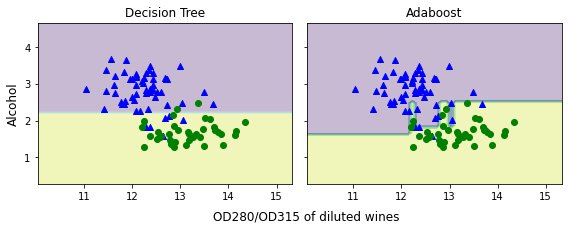

In [29]:
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.tight_layout()
plt.text(0, -0.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)
plt.show()

- 앙상블 학습은 개별 분류기에 비해 계산 복잡도가 높다는 점

**그라디언트 부스팅**

- 에이다부스트와 그레디언트 부스팅의 전반적인 개념은 같음 (깊이가 1인 결정 트리 등)
- 다른 점은 가중치를 업데이트 하는 방법과 학습기를 연결하는 방법
- 사이킷런의 `GradientBoostingClassifier` 클래스가 존재
- `XGBoost`보다 바른 그레디언트 부스팅 구현인 `HistGradientBoostingClassifier`가 추가됨
- 그라디언트 부스팅은 약한 학습기가 만든 잔차 오차에 대해 학습하는 새로운 학습기를 추가함

In [30]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
gbrt = GBC(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)
gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)
print('그라디언트 부스팅의 훈련 정확도/테스트 정확도: %.3f / %.3f' % (gbrt_train_score, gbrt_test_score))

그라디언트 부스팅의 훈련 정확도/테스트 정확도: 1.000 / 0.917


- `learning_rate`: 각 트리가 오차에 기여하는 정도를 조절, 작으면 성능은 높아지지만 많은 트리 필요 (default: 0.1)
- `loss`: 그라디언트 부스팅이 사용하는 손실함수(`log_loss`- 로지스틱 회귀, `ls`- 최소 제곱)
- 그라디언트 부스팅이 오차를 학습하기 위해 사용하는 학습기는 `DecisionTreeRegressor`
- `DecisionTreeRegressor`의 불순도 조건은 `'squared_error'`, `'absolute_error'` 등이 있음
- 이에 따라 그라디언트 부스팅의 `criterion` 매개변수도 `DecisionTreeRegressor`의 불순도 조건을 따라서 `'squared_error'`, `'mae'`, '`friedman_mse(default)` 사용
- `mae` 사용시 그라디언트 부스팅 결과가 좋지 않기에 삭제
- `subsample`: 1.0보다 작은 값으로 지정하면 훈련 데이터셋에서 `subsample` 매개변수에 지정된 비율만큼 랜덤하게 샘플링하여 트리를 훈련
- 이를 확률적 그라디언트 부스팅이라고 함
- 랜덤 포레스트나 에이다부스트의 부트스트랩 샘플링과 비슷하게 과대적합을 줄이는 효과를 냄
- 남은 샘플을 사용하여 OOB 점수도 계산 가능
- `subsample < 1.0`일 때, 그라디언트 부스팅 객체의 `oob_improvement_` 속성에 이전 트리의 OOB 손실 값에서 현재 트리의 OOB 손실을 뺀 값이 기록되어 있음
- 이 값에 음수를 취해 누적하면 트리가 추가되면서 과대적합되는 지점을 찾을 수 있음

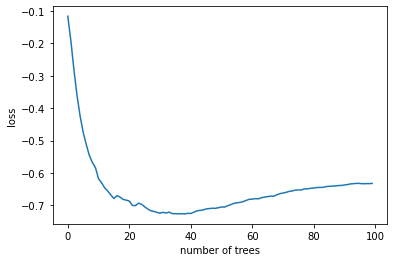

In [31]:
gbrt = GBC(n_estimators=100, subsample=0.5, random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)
plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')
plt.show()

- 사이킷런 0.20 버전부터는 그라디언트 부스팅에 조기종료 기능을 지원하기 위한 매개변수 `n_iter_no_change, validation_fraction, tol`이 추가되었음
- 훈련 데이터에서 `validation_fraction` 비율 (기본값 0.1)만큼 떼어 내어 측정한 손실이 `n_tier_no_change` 반복 동안에 `tol` 값(기본값 1e-4) 이상 향상되지 않으면 훈련을 멈춤

**히스토그램 기반 부스팅**

- 입력 특성을 256개의 구간으로 나누어 노드를 분할에 사용
- 일반적으로 샘플 개수가 1만 개보다 많은 경우 그라디언트 부스팅보다 히스토그램 기반 부스팅이 훨씬 빠름

In [32]:
from sklearn.ensemble import HistGradientBoostingClassifier as HBC
hgbc = HBC(random_state=1)
hgbc.fit(X_train, y_train)
hgbc_train_score = hgbc.score(X_train, y_train)
hgbc_test_score = hgbc.score(X_test, y_test)
print('히스토그램 기반 부스팅의 훈련 정확도/테스트 정확도: %.3f / %.3f' % (hgbc_train_score, hgbc_test_score))

히스토그램 기반 부스팅의 훈련 정확도/테스트 정확도: 0.979 / 0.917


- `categorical_features` 매개변수에 boolean 배열이나 정수 인덱스 배열을 전달하여 범주형 특성을 알려주면 범주형 특성에 그대로 적용 가능

**XGBoost**

- `tree_method` 매개변수를 `'hist'`로 지정하여 히스토그램 기반 부스팅을 사용할 수 있음

In [34]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', eval_metric='logloss', use_label_encoding=False, random_state=1)
xgb.fit(X_train, y_train)
xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)
print('XGBoost의 훈련 정확도/테스트 정확도: %.3f / %.3f' % (xgb_train_score, xgb_test_score))

[21:22:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "use_label_encoding" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBoost의 훈련 정확도/테스트 정확도: 0.979 / 0.917


c:\Users\yunjc\anaconda3\envs\main\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


**LightGBM**

- 마이크로소프트에서 만듦
- 사이킷런의 히스토그램 기반 부스팅은 LightGBM에서 영향을 받음

In [36]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)
lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)
print('LightGBM의 훈련 정확도/테스트 정확도: %.3f / %.3f' % (lgb_train_score, lgb_test_score))

LightGBM의 훈련 정확도/테스트 정확도: 0.979 / 0.917
